In [1]:
import os
import numpy as np
import pandas as pd
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
from hough import *
from conformal_map import *
from tqdm import tqdm

%matplotlib inline

In [2]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
selected_indices = hits.index[cond].tolist()
selected_hits = hits.iloc[selected_indices]
selected_truth = truth.iloc[selected_indices]
trackId = selected_truth.particle_id.unique()[505]
track = selected_truth[selected_truth.particle_id == trackId]

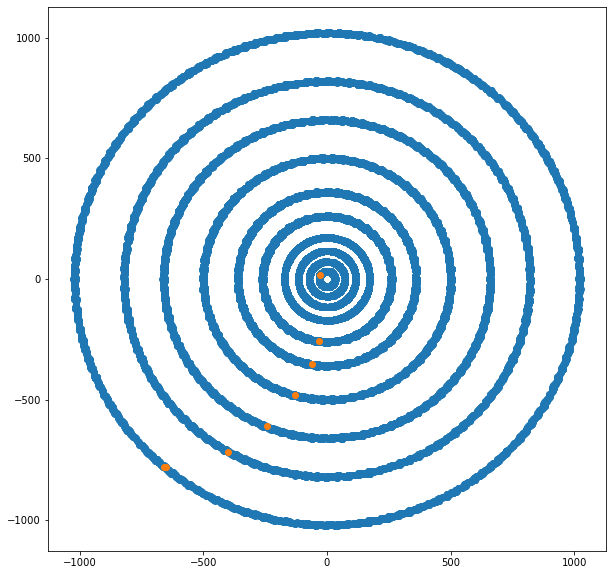

In [3]:
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.plot(selected_hits.x, selected_hits.y, 'o')
ax.plot(track.tx, track.ty, 'o')
plt.show()

In [4]:
B = 1000
def convertTrackToImage(trackId):
    first = True
    imageBins = B
    image = np.empty((imageBins, 0))
    for volume in [8, 13, 17]:
        #print(volume)
        for layer in hits[hits.volume_id == volume].layer_id.unique():
            #print(layer)
            truthVol8 = truth.iloc[hits.index[(hits.volume_id == volume)].tolist()]
            hitsVol8 = hits.iloc[hits.index[(hits.volume_id == volume)].tolist()]
            t = truthVol8.loc[(hitsVol8.layer_id == layer) & (truthVol8.particle_id == trackId)]
            r = np.power(t.tx, 2) + np.power(t.ty, 2)
            theta = np.arctan(t.ty / t.tx)
            #print(theta)
            thetaRange = np.pi * 2
            indicesFloat = (theta / thetaRange) * imageBins + imageBins / 2
            #print(indicesFloat)
            indices = np.array(list(map(int, indicesFloat)))
            indices = np.reshape(indices, (len(indices), 1))
            bins = np.zeros((imageBins, 1))
            if first:
                if len(indices) == 0:
                    image = np.hstack([image, np.zeros((imageBins, 1))])
                    continue
                firstIndex = max(indices[0])
                moveRange = firstIndex - imageBins // 2
                first = False
            indices = (indices - moveRange) % imageBins
            for i, index in enumerate(indices):
                bins[index, 0] += 1
            image = np.hstack([image, bins])
            #print(indices)
    return image

In [5]:
images = [] # Currently using 0-9 on event 101 and 0-9 on 103 and 0-3 on 104 
train_y = np.empty((0, 1))

In [143]:
for k in range(4):
    print("round:", k)
    event_prefix = 'event00000104' + str(k)
    hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
    cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
    selected_indices = hits.index[cond].tolist()
    selected_hits = hits.iloc[selected_indices]
    selected_truth = truth.iloc[selected_indices]
    # Create training set with tracks that are minimum of 5 hits
    tracks = selected_truth.particle_id.unique()
    validTracks = []
    for track in tracks:
        if track == 0:
            continue
        numberHits = selected_truth[selected_truth.particle_id == track].shape[0]
        t = selected_truth[selected_truth.particle_id == track]
        if numberHits >= 11:
            validTracks.append(track)

    nr = len(validTracks)
    for j in tqdm(range(nr)):
        trackId = validTracks[j]
        image = convertTrackToImage(trackId)
        images.append(image)
        #print(c)
    # Create train_Y (the momentum)
    for j, track in enumerate(validTracks[0:nr]):
        track = validTracks[j]
        if track == 0:
            continue
        t = selected_truth[selected_truth.particle_id == track]
        px = t['tpx'].mean()
        py = t['tpy'].mean()
        #pz = t['tpz'].mean()
        p = np.sqrt(px**2 + py**2) #+ pz**2)# / (0.3 * 0.001 * 2)
        train_y = np.append(train_y, [p])
    


round: 0


100%|██████████████████████████████████████████████████████████████████████████████| 1705/1705 [06:21<00:00,  4.47it/s]


round: 1


100%|██████████████████████████████████████████████████████████████████████████████| 1306/1306 [04:30<00:00,  4.83it/s]


round: 2


100%|██████████████████████████████████████████████████████████████████████████████| 1406/1406 [04:53<00:00,  4.79it/s]


round: 3


100%|██████████████████████████████████████████████████████████████████████████████| 1422/1422 [05:21<00:00,  4.42it/s]


In [144]:
#images_val = [] Currently using 0-4 on 102.
#train_y_val = np.empty((0, 1))
for k in range(3, 5):
    print("round:", k)
    event_prefix = 'event00000102' + str(k)
    hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
    cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
    selected_indices = hits.index[cond].tolist()
    selected_hits = hits.iloc[selected_indices]
    selected_truth = truth.iloc[selected_indices]
    # Create training set with tracks that are minimum of 5 hits
    tracks = selected_truth.particle_id.unique()
    validTracks = []
    for track in tracks:
        if track == 0:
            continue
        numberHits = selected_truth[selected_truth.particle_id == track].shape[0]
        t = selected_truth[selected_truth.particle_id == track]
        if numberHits >= 12:
            validTracks.append(track)

    nr = len(validTracks)
    for j in tqdm(range(nr)):
        trackId = validTracks[j]
        image = convertTrackToImage(trackId)
        images_val.append(image)
        #print(c)
    # Create train_Y (the momentum)
    for j, track in enumerate(validTracks[0:nr]):
        if track == 0:
            continue
        t = selected_truth[selected_truth.particle_id == track]
        px = t['tpx'].mean()
        py = t['tpy'].mean()
        #pz = t['tpz'].mean()
        p = np.sqrt(px**2 + py**2) #+ pz**2)# / (0.3 * 0.001 * 2)
        train_y_val = np.append(train_y_val, [p])
    


round: 3


100%|██████████████████████████████████████████████████████████████████████████████| 1167/1167 [05:43<00:00,  3.40it/s]


round: 4


100%|██████████████████████████████████████████████████████████████████████████████| 1020/1020 [04:15<00:00,  3.99it/s]


In [145]:
train_y = np.reshape(train_y, (len(train_y), 1))
train_X = np.reshape(images, (len(images), B, 10, 1))

In [146]:
test_X = np.reshape(images_val, (len(images_val), B, 10, 1))
test_y = np.reshape(train_y_val, (len(train_y_val), 1))

In [147]:
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(33602, 1000, 10, 1) (33602, 1)
(4703, 1000, 10, 1) (4703, 1)


In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras import backend as K
from keras import regularizers
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [148]:
def build_model():
    model = keras.Sequential([
        layers.Conv2D(8, (3, 3), activation="relu", input_shape=(B, 10, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(20, activation="relu"),
        layers.Dense(1)
    ])

    #optimizer = keras.optimizers.RMSprop(learning_rate=0.00001) #0.00001 works good
    model.compile(loss='mae', optimizer="adam")
    return model

In [149]:
model = build_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 998, 8, 8)         80        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 499, 4, 8)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 497, 2, 16)        1168      
_________________________________________________________________
flatten_10 (Flatten)         (None, 15904)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 20)                318100    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 21        
Total params: 319,369
Trainable params: 319,369
Non-trainable params: 0
_______________________________________________

In [150]:
EPOCHS = 50
print(train_X.shape)
print(train_y.shape)
history = model.fit(train_X, train_y, validation_split=0.1, epochs=EPOCHS) 

(33602, 1000, 10, 1)
(33602, 1)
Train on 30241 samples, validate on 3361 samples
Epoch 1/50
30241/30241 [==============================] - 10s 333us/step - loss: 0.1243 - val_loss: 0.2296
Epoch 2/50
30241/30241 [==============================] - 9s 306us/step - loss: 0.0728 - val_loss: 0.1954
Epoch 3/50
30241/30241 [==============================] - 9s 306us/step - loss: 0.0615 - val_loss: 0.1946
Epoch 4/50
30241/30241 [==============================] - 9s 306us/step - loss: 0.0554 - val_loss: 0.1440
Epoch 5/50
30241/30241 [==============================] - 9s 308us/step - loss: 0.0513 - val_loss: 0.1193
Epoch 6/50
30241/30241 [==============================] - 9s 307us/step - loss: 0.0474 - val_loss: 0.1161
Epoch 7/50
30241/30241 [==============================] - 10s 331us/step - loss: 0.0455 - val_loss: 0.1055
Epoch 8/50
30241/30241 [==============================] - 10s 315us/step - loss: 0.0445 - val_loss: 0.1118
Epoch 9/50
30241/30241 [==============================] - 10s 314us/

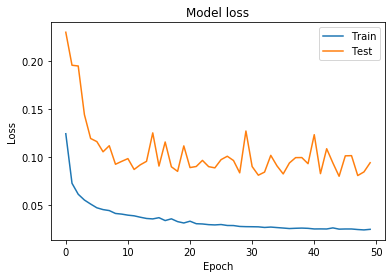

In [151]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [152]:
test_loss = model.evaluate(test_X, test_y)
print(test_loss)

train_loss = model.evaluate(train_X, train_y)
print(train_loss)

4703/4703 [==============================] - 1s 155us/step
0.03665029948730558
33602/33602 [==============================] - 5s 143us/step
0.029171932983360124


In [154]:
i = 10231
prediction = model.predict(np.reshape(train_X[i], (1, B, 10, 1)))
print(prediction, " ", train_y[i])

[[0.9011008]]   [0.87350908]


In [111]:
preds = []
for i in range(len(test_X)):
    prediction = model.predict(np.reshape(test_X[i], (1, B, 10, 1)))
    preds.append(prediction[0][0])

In [112]:
f = open("output", "w")
for i in range(len(test_X)):
    f.write(str((test_y[i] - preds[i])[0]) + "\n")

In [99]:
f.close()

In [130]:
percentages = []
for i in tqdm(range(len(train_X))):
    prediction = model.predict(np.reshape(train_X[i], (1, B, 10, 1)))
    percentages.append(abs((prediction - train_y[i]) / train_y[i]) * 100)
percentages = np.array(percentages)
print("mean percentage error:", np.mean(percentages))

100%|███████████████████████████████████████████████████████████████████████████| 22224/22224 [01:47<00:00, 205.94it/s]

mean percentage error: 3.8402055899023986


In [153]:
percentages = []
for i in tqdm(range(len(test_X))):
    prediction = model.predict(np.reshape(test_X[i], (1, B, 10, 1)))
    percentages.append(abs((prediction - test_y[i]) / test_y[i]) * 100)
percentages = np.array(percentages)
print(np.mean(percentages))

100%|█████████████████████████████████████████████████████████████████████████████| 4703/4703 [00:15<00:00, 297.67it/s]

4.0826213799786935


Try a bin process of images

In [257]:
# Did not work good at all.
def track_to_image(trackId): 
    track = selected_truth[selected_truth.particle_id == trackId]
    import numpy as np
    s = 100
    shape = [s,s]
    bins = np.zeros(shape, dtype=int)

    xmin = np.min(track.tx)
    xmax = np.max(track.tx)
    xwidth = xmax - xmin
    xind = (((track.tx - xmin) / xwidth) * shape[0] - 1)
    xind /= 5
    xind += s / 2
    ymin = np.min(track.ty)
    ymax = np.max(track.ty)
    ywidth = ymax - ymin
    yind = (((track.ty - ymin) / ywidth) * shape[0] - 1)
    yind /= 5
    yind += s / 2
    for ind in zip(xind, yind):
        indx = (int(round(ind[0])), int(round(ind[1])))
        bins[indx] += 1

    return bins